## **HarvestGuard**
#### This project focuses on Leaf Disease Classification using an Afrocentric dataset. The dataset is specifically curated to represent diverse agricultural scenarios across various African regions. It comprises annotated photos of leaves from a variety of crops, showcasing both healthy specimens and those affected by diseases. The goal is to develop a classification system leveraging machine learning techniques to accurately identify and categorize crop diseases based on the subtle symptoms observed in the annotated images. By using an Afrocentric dataset, the project aims to enhance the effectiveness of disease classification models tailored to the unique agricultural landscape of Africa (Responsible AI Lab, 2023)







In [ ]:
# Import libraries
!pip install opendatasets
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import re
import pathlib
import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from imgaug import augmenters as iaa
# imageio library will be used for image input/output
import imageio
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight
import shutil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### **Afrocentric (African) Crop Dataset**
#### The Afrocentric Crop Disease dataset on Kaggle.The dataset includes annotated images of crops from Ghana, categorizing them based on disease types. Each category contains information on disease categories, image sizes, bounding boxes, and sample images

In [ ]:
# Download datset from Kaggle to notebook directory
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Skipping, found downloaded files in "./crop-disease-ghana" (use force=True to force download)


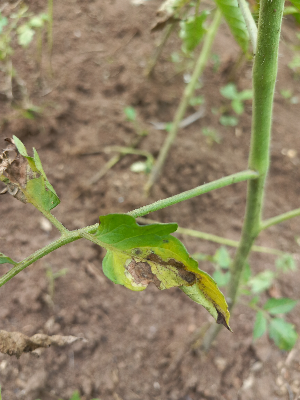

In [ ]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [ ]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['Pepper',
 'Tomato',
 'Corn',
 'dataset_labels.csv',
 'label_map.pbtxt',
 'catyegory_index.pbtxt',
 'label_map.txt',
 'label_map.json']

In [ ]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


In [ ]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

#### **Addressing rare catagories of diseases**

In [ ]:
# Merge similar classes
labels_df.replace(['Pepper Late Blight','Pepper Early Blight'],'Pepper Leaf Blight',inplace = True)
labels_df.replace(['Tomato Late Blight','Tomato Early Blight'],'Tomato Leaf Blight',inplace = True)

In [ ]:
# Drop labels with too little data or multiple diseases
labels_df = labels_df[labels_df['disease'] != 'Tomato Mosaic']
labels_df = labels_df[labels_df['disease'] != 'Corn Northern Leaf Blight']
labels_df = labels_df[labels_df['disease'] != 'Pepper Leaf Mosaic']
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Leaf Blight           7993
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Bacterial Spot        2780
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Pepper Leaf Blight           1660
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Name: disease, dtype: int64

In [ ]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in labels_df['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
labels_df['img_path'] = new_img
labels_df['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'

In [ ]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in labels_df['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
labels_df['ann_path'] = new_ann
labels_df['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'

In [ ]:
# Labels for categories
labels = {}
lab_len = len(np.unique(labels_df['disease']))
for j,i in zip(np.unique(labels_df['disease']),range(1,lab_len + 1)):
  labels[j] = i
print(labels)

{'Corn Cercospora Leaf Spot': 1, 'Corn Common Rust': 2, 'Corn Healthy': 3, 'Corn Streak': 4, 'Pepper Bacterial Spot': 5, 'Pepper Cercospora': 6, 'Pepper Fusarium': 7, 'Pepper Healthy': 8, 'Pepper Leaf Blight': 9, 'Pepper Leaf Curl': 10, 'Pepper Septoria': 11, 'Tomato Bacterial Spot': 12, 'Tomato Fusarium': 13, 'Tomato Healthy': 14, 'Tomato Leaf Blight': 15, 'Tomato Leaf Curl': 16, 'Tomato Septoria': 17}


In [ ]:
# Use categorical labels to make new target column
enc_labels = []
for i in labels_df['disease']:
  for k,v in labels.items():
    if i == k :
      enc_labels.append(labels[i])
labels_df['label'] = enc_labels
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


<Axes: xlabel='crop', ylabel='count'>

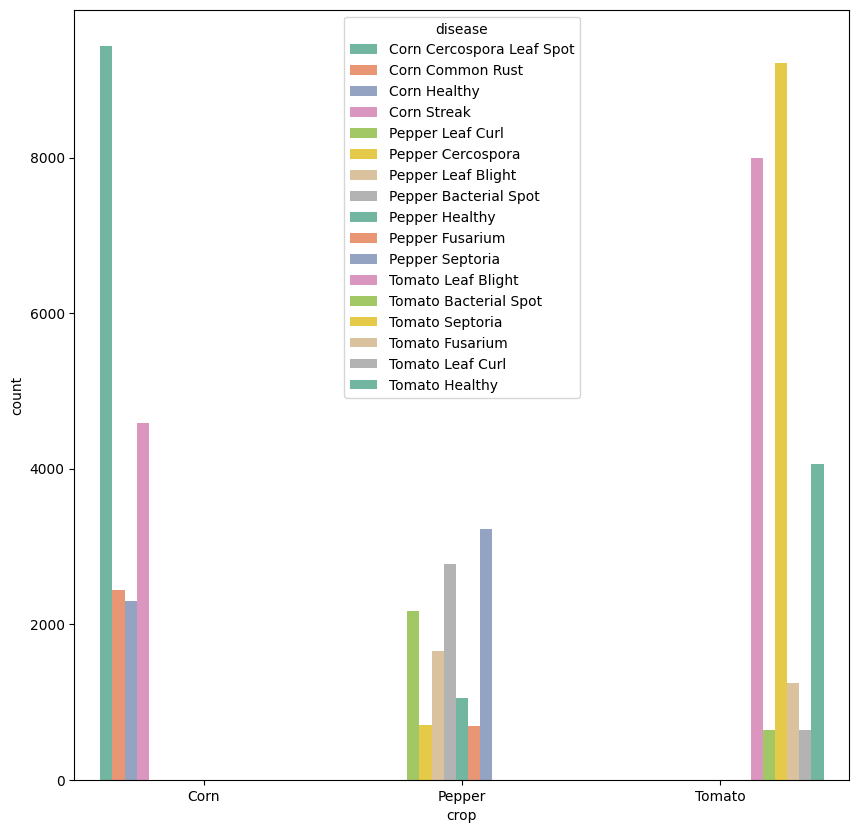

In [ ]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [ ]:
# Drop duplicates
no_duplicates = labels_df.drop_duplicates(subset = 'img_path',ignore_index=True)
no_duplicates.reset_index()
no_duplicates.shape

(6919, 14)

<Axes: xlabel='crop', ylabel='count'>

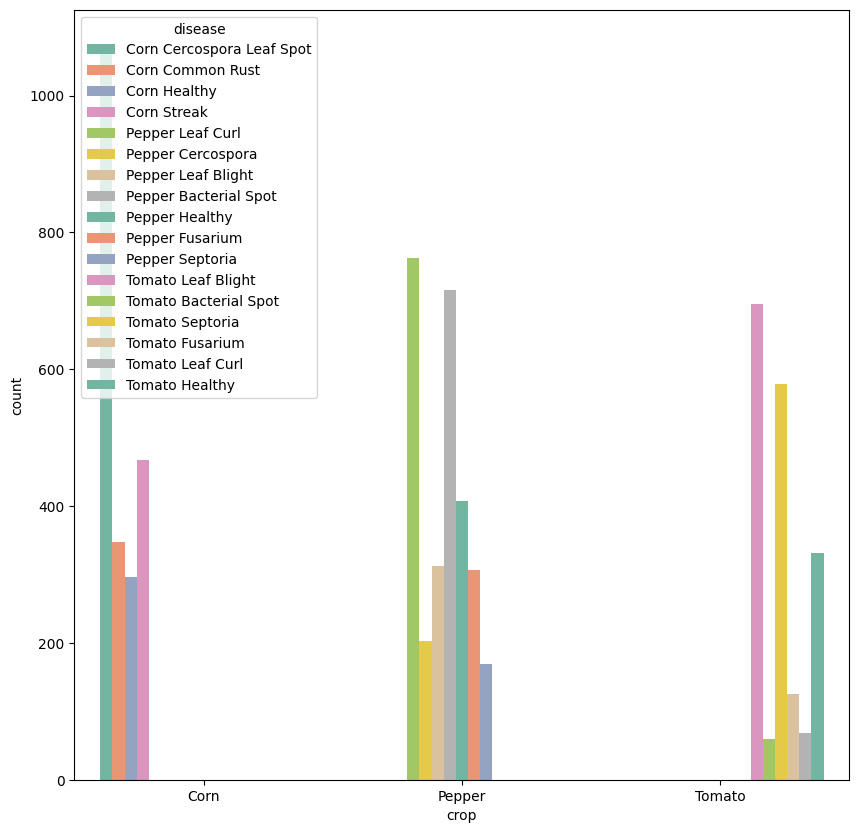

In [ ]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = no_duplicates['crop'],hue = no_duplicates['disease'],palette = 'Set2')

In [ ]:
# Disease value counts
no_duplicates['disease'].value_counts()

Corn Cercospora Leaf Spot    1072
Pepper Leaf Curl              763
Pepper Bacterial Spot         716
Tomato Leaf Blight            696
Tomato Septoria               579
Corn Streak                   467
Pepper Healthy                408
Corn Common Rust              348
Tomato Healthy                331
Pepper Leaf Blight            312
Pepper Fusarium               306
Corn Healthy                  296
Pepper Cercospora             203
Pepper Septoria               169
Tomato Fusarium               126
Tomato Leaf Curl               68
Tomato Bacterial Spot          59
Name: disease, dtype: int64

### **Data Analysis**
#### Graph shows class imbalance in selected dataset. There are catagories such as Corn  Cercospora Leaf, Pepper Lead Curl, Pepper Bacteria Spot and others are contributing to majority of sample data. This will lead us in our next section where we addressed class imbalances.

### **Data Augmentation**
####  In order to address class imbalance problem, there should be a combination of resampling and data augmentation.

In [ ]:
# Modifed from:
# https://medium.com/@a.karazhay/guide-augment-images-and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-notebook-9b263e414dac
# Augments bounding box coordiantes along with their respective images

# Function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#  Convert bounding box object to array
    bbs_array = bbs_object.to_xyxy_array()
    # Convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

def image_aug(df,aug_images_path, image_prefix, augmentor,ref_df):
    # Create data frame to store augmented image info
    aug_bbs_xy = pd.DataFrame(columns=labels_df.columns)
    grouped = df.groupby('filename')
    # Group data by filename
    for filename,i in zip(df['filename'].unique(),range(len(df))):
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        # Read image
        image = imageio.imread(ref_df['img_path'][i])
        # Find bounding box coordinates put and put them into an array
        bb_array = group_df.drop(['filename', 'disease', 'crop', 'width', 'height', 'depth',
                                  'ann_path', 'img_path','label','shape'], axis=1).values
    #  Pass bounding box coordinates to Img Aug
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)

        # Apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
        # Disregard boxes which have fallen out of image
        bbs_aug = bbs_aug.remove_out_of_image()
        # Clip  boxes which are partially outside of image
        bbs_aug = bbs_aug.clip_out_of_image()

      # Don't perform any actions with the image if there are no bounding boxes left in it
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        else:
            # Write augmented image to a file
            os.chdir(aug_images_path)
            name = image_prefix+'_'+filename
            cv2.imwrite(name, image_aug)
            # Create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
            # Rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+'_'+x)
            # Create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
            # Concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
            # Append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    # Return dataframe with updated images and bounding boxes annotations
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy


In [ ]:
# Augmentors to use
aug_flip = iaa.Sequential([
    iaa.Fliplr(1)
])
aug_rotate = iaa.Sequential([
    iaa.Affine(rotate=(-60, 60))
])

aug_blur = iaa.Sequential([
    iaa.GaussianBlur(sigma=(2.0, 3.0))
])

aug_noise = iaa.Sequential([
  iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [ ]:
# Going to augment rare classes the append augmented data to labels_df
tlc_df = labels_df[labels_df['disease']=='Tomato Leaf Curl'].reset_index()
tbs_df = labels_df[labels_df['disease']=='Tomato Bacterial Spot'].reset_index()
pc_df = labels_df[labels_df['disease']=='Pepper Cercospora'].reset_index()
ps_df = labels_df[labels_df['disease']=='Pepper Septoria'].reset_index()
tf_df = labels_df[labels_df['disease']=='Tomato Fusarium'].reset_index()

In [ ]:
# Make folders to store augmented images
!mkdir Tomato_Leaf_Curl_Aug
!mkdir Tomato_Bacterial_Spot_Aug
!mkdir Pepper_Cercospora_Aug
!mkdir Pepper_Septoria_Aug
!mkdir Tomato_Fusarium_Aug

In [ ]:
# Create augmented data set
def make_aug(df,aug_dir):
  aug_list = [aug_flip,aug_rotate,aug_blur,aug_noise]

  aug_df = image_aug(df[labels_df.columns],
                   aug_dir, 'flip', aug_list[0],df)
  label = ['rotate','blur','noise']
  for a,n in zip(aug_list[1:],label):
    aug_df = aug_df.append(image_aug(df[labels_df.columns],
                   aug_dir, n, a,df))
  # Drop rows with null
  aug_df = aug_df.dropna()
  return aug_df

In [ ]:
# Make augmented datasets
tlc_aug = make_aug(tlc_df,'/content/Tomato_Leaf_Curl_Aug').reset_index()
tbs_aug = make_aug(tbs_df,'/content/Tomato_Bacterial_Spot_Aug').reset_index()
pc_aug = make_aug(pc_df,'/content/Pepper_Cercospora_Aug').reset_index()
ps_aug = make_aug(ps_df,'/content/Pepper_Septoria_Aug').reset_index()
tf_aug = make_aug(tf_df,'/content/Tomato_Fusarium_Aug').reset_index()

In [ ]:
tlc_aug.head()

,index,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,0,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,1533.429932,1586.780884,1840.773926,2167.487305,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
1,1,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,618.202393,1597.042847,1096.607178,2033.170288,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
2,2,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,2577.438477,902.496277,2912.614014,1354.034424,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
3,3,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,1315.911865,1372.759277,1736.795410,1517.977295,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
4,4,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,2185.676270,1207.585449,2512.000732,1416.671509,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16


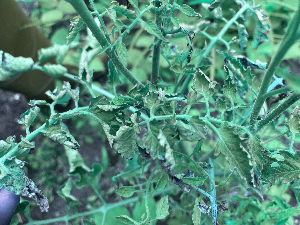

In [ ]:
# Display augmented image
p = '/content/Tomato_Leaf_Curl_Aug/' + tlc_aug['filename'][0]
test_img=cv2.imread(p)
def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [ ]:
# Replace image paths
tlc_aug['img_path'] = '/content/Tomato_Leaf_Curl_Aug/' + tlc_aug['filename']
tbs_aug['img_path'] = '/content/Tomato_Bacterial_Spot_Aug/' + tbs_aug['filename']
pc_aug['img_path'] = '/content/Pepper_Cercospora_Aug/' + pc_aug['filename']
ps_aug['img_path'] = '/content/Pepper_Septoria_Aug/' + ps_aug['filename']
tf_aug['img_path'] = '/content/Tomato_Fusarium_Aug/' + tf_aug['filename']

In [ ]:
# Drop index column
tlc_aug = tlc_aug.drop(labels = 'index',axis = 1)
tbs_aug = tbs_aug.drop(labels = 'index',axis = 1)
pc_aug = pc_aug.drop(labels = 'index',axis = 1)
ps_aug = ps_aug.drop(labels = 'index',axis = 1)
tf_aug = tf_aug.drop(labels = 'index',axis = 1)

In [ ]:
# Append to labels_df
labels_df = labels_df.append(tlc_aug)
labels_df = labels_df.append(tbs_aug)
labels_df = labels_df.append(pc_aug)
labels_df = labels_df.append(ps_aug)
labels_df = labels_df.append(tf_aug)
labels_df = labels_df.reset_index()

In [ ]:
labels_df.shape

(70259, 15)

In [ ]:
# Drop duplicates
no_duplicates = labels_df.drop_duplicates(subset = 'filename',ignore_index=True)
no_duplicates.shape

(9191, 15)

In [ ]:
no_duplicates['disease'].value_counts()

Pepper Cercospora            1096
Corn Cercospora Leaf Spot    1021
Pepper Septoria               835
Pepper Leaf Curl              760
Pepper Bacterial Spot         706
Tomato Leaf Blight            632
Tomato Fusarium               570
Corn Streak                   467
Tomato Leaf Curl              447
Tomato Bacterial Spot         412
Tomato Septoria               409
Pepper Healthy                366
Tomato Healthy                331
Pepper Leaf Blight            312
Pepper Fusarium               306
Corn Healthy                  280
Corn Common Rust              241
Name: disease, dtype: int64

In [ ]:
# Create final balanced dataset
balanced = pd.DataFrame(columns = labels_df.columns)
for i in no_duplicates['disease'].unique():
  df = no_duplicates[no_duplicates['disease'] == i]
  if len(df)>200:
    samp = df.sample(n = 200,random_state = 24)
    balanced = balanced.append(samp)
  else:
    balanced = balanced.append(df)

In [ ]:
# Using less data because of computational constraints
balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    200
Pepper Fusarium              200
Tomato Leaf Curl             200
Tomato Fusarium              200
Tomato Septoria              200
Tomato Bacterial Spot        200
Tomato Leaf Blight           200
Pepper Septoria              200
Pepper Healthy               200
Corn Common Rust             200
Pepper Bacterial Spot        200
Pepper Leaf Blight           200
Pepper Cercospora            200
Pepper Leaf Curl             200
Corn Streak                  200
Corn Healthy                 200
Tomato Healthy               200
Name: disease, dtype: int64

In [ ]:
# Create final balanced df
balanced_df = pd.DataFrame(columns = balanced.columns)
for i in np.unique(balanced['filename']):
  df = labels_df[labels_df['filename'] == i]
  balanced_df = balanced_df.append(df,ignore_index = True)
#balanced_df = balanced_df.reset_index()
#balanced_df = balanced_df.drop(labels = ['index','level_0'],axis = 1)
balanced_df.head()



,index,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,21667,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,938.970994,1550.683230,1672.769337,2274.989648,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
1,21668,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,281.933702,1781.283644,611.042818,2365.175983,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
2,19004,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1199.818892,1273.706070,1272.400568,1334.632588,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
3,19005,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,952.734375,1139.371672,1015.887784,1173.418530,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
4,19006,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1037.791193,993.439830,1091.313920,1037.018104,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6


In [ ]:
# Dropping unecessary columns
balanced_df = balanced_df.drop(labels =['index'],axis = 1)
balanced_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,938.970994,1550.683230,1672.769337,2274.989648,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
1,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,281.933702,1781.283644,611.042818,2365.175983,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
2,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1199.818892,1273.706070,1272.400568,1334.632588,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
3,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,952.734375,1139.371672,1015.887784,1173.418530,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
4,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1037.791193,993.439830,1091.313920,1037.018104,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6


In [ ]:
df_balanced = pd.DataFrame(columns = labels_df.columns)
for i in np.unique(balanced_df['disease']):
  df = balanced_df[balanced_df['disease'] == i]
  if len(df)>200:
    samp = df.sample(n = 200,random_state = 24)
    df_balanced = df_balanced.append(samp,ignore_index = True)
  else:
    df_balanced = df_balanced.append(df,ignore_index = True)


In [ ]:
df_balanced = df_balanced.drop(labels =['index'],axis = 1)
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230526_114545.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2089.895178,897.998932,2172.578616,1003.483405,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230526_103506(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2717.148847,592.949243,2822.641509,672.775330,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230525_111356(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2941.199173,1275.034169,3076.168160,1407.181183,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_110802.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2857.733711,753.781004,2941.529745,826.064469,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230526_102705.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2976.603774,1257.216324,3062.138365,1348.446137,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


### **Multi-class object detection and bounding box regression**
#### A single forward pass of our multi-class object detector will result in:
#### 1. The predicted bounding box coordinates of the object in the image
#### 2. The predicted class label of the object in the image

#### **Model Design**
#### Branch #1: A regression layer set, just like in the single-class object detection case
#### Branch #2: An additional layer set, this one with a softmax classifier used to predict class labels

In [ ]:
# Initialize parameters

width=224
height=224
depth= 3
epoch_= 25
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
INIT_LR = 1e-3


####  We use resize and img_to_array method of open cv to ensure that our image size is 224x 224 pixels for training with VGG16 followed by converting to array format

In [ ]:
def convert_image_to_array(image_dir):

    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
df_balanced.shape

(3400, 14)

In [ ]:
# scale the bounding box coordinates relative to the spatial dimensions of the input image
new_xmin = []
new_ymin = []
new_xmax = []
new_ymax = []

for i in range(df_balanced.shape[0]):
  w=df_balanced['width'][i]
  h=df_balanced['height'][i]
  xmin=df_balanced['xmin'][i]
  ymin=df_balanced['ymin'][i]
  xmax=df_balanced['xmax'][i]
  ymax=df_balanced['ymax'][i]
  new_xmin.append(float(xmin) / w)
  new_ymin.append(float(ymin) / h)
  new_xmax.append(float(xmax) / w)
  new_ymax.append(float(ymax) / h)

df_balanced['xmin'] = new_xmin
df_balanced['ymin'] = new_ymin
df_balanced['xmax'] = new_xmax
df_balanced['ymax'] = new_ymax
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230526_114545.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.512229,0.489106,0.532495,0.546560,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230526_103506(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.665968,0.322957,0.691824,0.366435,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230525_111356(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.720882,0.694463,0.753963,0.766439,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_110802.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.700425,0.410556,0.720963,0.449926,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230526_102705.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.729560,0.684758,0.750524,0.734448,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


#### Finally, we populate those four lists that we initialized : (1) image_list (array format), (2) ImagePaths_list  (3) label_list(Disease catagories), and (4) bboxes_list(xmin ymin, xmax, ymax co-ordinates)

In [ ]:
image_list, label_list, bboxes_list, imagePaths_list = [], [], [], []

indx=0
i=0
try:
  for img_dir in df_balanced['img_path']:
  #for i in range(2):
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
      image_list.append(convert_image_to_array(img_dir))
      imagePaths_list.append(df_balanced['img_path'][indx])
      label_list.append(df_balanced['disease'][indx])
      bboxes_list.append((df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx]))
      indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [ ]:
data, labels, bboxes, imagePaths = [], [], [], []
data = np.array(image_list, dtype="float32") / 255.0
labels = np.array(label_list)
bboxes = np.array(bboxes_list, dtype="float32")
imagePaths = np.array(imagePaths_list)

In [ ]:
print (data[0], labels[0], bboxes[0], imagePaths[0])

[[[0.23921569 0.73333335 0.50980395]
  [0.35686275 0.8156863  0.60784316]
  [0.33333334 0.79607844 0.59607846]
  ...
  [0.         0.36862746 0.23137255]
  [0.         0.3137255  0.14509805]
  [0.         0.2784314  0.10980392]]

 [[0.1254902  0.5921569  0.36078432]
  [0.12941177 0.5882353  0.35686275]
  [0.25490198 0.75686276 0.5411765 ]
  ...
  [0.         0.30980393 0.11764706]
  [0.         0.27450982 0.10588235]
  [0.         0.26666668 0.09411765]]

 [[0.08627451 0.59607846 0.34901962]
  [0.12156863 0.59607846 0.34901962]
  [0.13725491 0.6        0.36862746]
  ...
  [0.         0.27450982 0.10588235]
  [0.         0.26666668 0.10588235]
  [0.         0.24313726 0.08235294]]

 ...

 [[0.5764706  0.73333335 0.60784316]
  [0.49411765 0.69411767 0.54509807]
  [0.39607844 0.62352943 0.4627451 ]
  ...
  [0.1254902  0.22745098 0.25490198]
  [0.08235294 0.19607843 0.21568628]
  [0.07843138 0.19215687 0.21176471]]

 [[0.49019608 0.69803923 0.5529412 ]
  [0.36078432 0.5921569  0.42745098]


#### One-hot encoded labels

In [ ]:
label_binarizer = LabelBinarizer()
if labels is not None:
  binarylabels = label_binarizer.fit_transform(labels)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [ ]:
print(labels.shape)

(2479,)


In [ ]:
split = train_test_split(data, binarylabels, bboxes, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
#(trainPaths, testPaths) = split[6:]

In [ ]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### **Pre-Trained Model VGG16**
VGG16: The CNN architecture to serve as the base network which we’ll (1) modify for multi-class bounding box regression and (2) then fine-tune on our dataset

VGG16 network is loaded with weights pre-trained on the ImageNet dataset. We leave off the fully-connected layer head (include_top=False), since we will be constructing a new layer head responsible for multi-output prediction (i.e., class label and bounding box location).

In [ ]:

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

#### Flatten the output of the network so we can construct our new layer
#### (1) The first branch, bboxHead, is responsible for predicting the bounding box (x, y)-coordinates of the object in the image.
#### (2) Our second branch, softmaxHead, is responsible for predicting the class label of the detected object

In [ ]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(label_binarizer.classes_), activation="softmax", name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
modell = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

### We are using categorical cross-entropy for our class label branch and mean squared error for our bounding box regression head.

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"bounding_box": "mean_squared_error",
	"class_label": "categorical_crossentropy"
	#"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"bounding_box": 1.0,
	"class_label": 1.0
	#"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
modell.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(modell.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"bounding_box": trainBBoxes,
	"class_label": trainLabels
	#"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"bounding_box": testBBoxes,
	"class_label": testLabels
	#"bounding_box": testBBoxes
}

### **Training multi-class object detector**
#### Our architecture has two branches in the layer head — the first branch to predict the bounding box coordinates and the second to predict the class label of the detected object

In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = modell.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BS,
	epochs=50,
	#class_weight=class_weights,
	verbose=1)

[INFO] training model...
Epoch 1/50
62/62 [==============================] - 19s 139ms/step - loss: 3.0276 - bounding_box_loss: 0.0585 - class_label_loss: 2.9690 - bounding_box_accuracy: 0.4347 - class_label_accuracy: 0.1906 - val_loss: 1.9419 - val_bounding_box_loss: 0.0535 - val_class_label_loss: 1.8884 - val_bounding_box_accuracy: 0.5262 - val_class_label_accuracy: 0.3407
Epoch 2/50
62/62 [==============================] - 4s 67ms/step - loss: 2.1131 - bounding_box_loss: 0.0487 - class_label_loss: 2.0644 - bounding_box_accuracy: 0.4851 - class_label_accuracy: 0.2481 - val_loss: 1.9010 - val_bounding_box_loss: 0.0539 - val_class_label_loss: 1.8471 - val_bounding_box_accuracy: 0.5302 - val_class_label_accuracy: 0.3770
Epoch 3/50
62/62 [==============================] - 4s 65ms/step - loss: 1.9877 - bounding_box_loss: 0.0459 - class_label_loss: 1.9418 - bounding_box_accuracy: 0.4634 - class_label_accuracy: 0.2960 - val_loss: 1.6535 - val_bounding_box_loss: 0.0586 - val_class_label_loss

#### **Visualizes our three loss components: the class label loss, bounding box loss, and total loss**

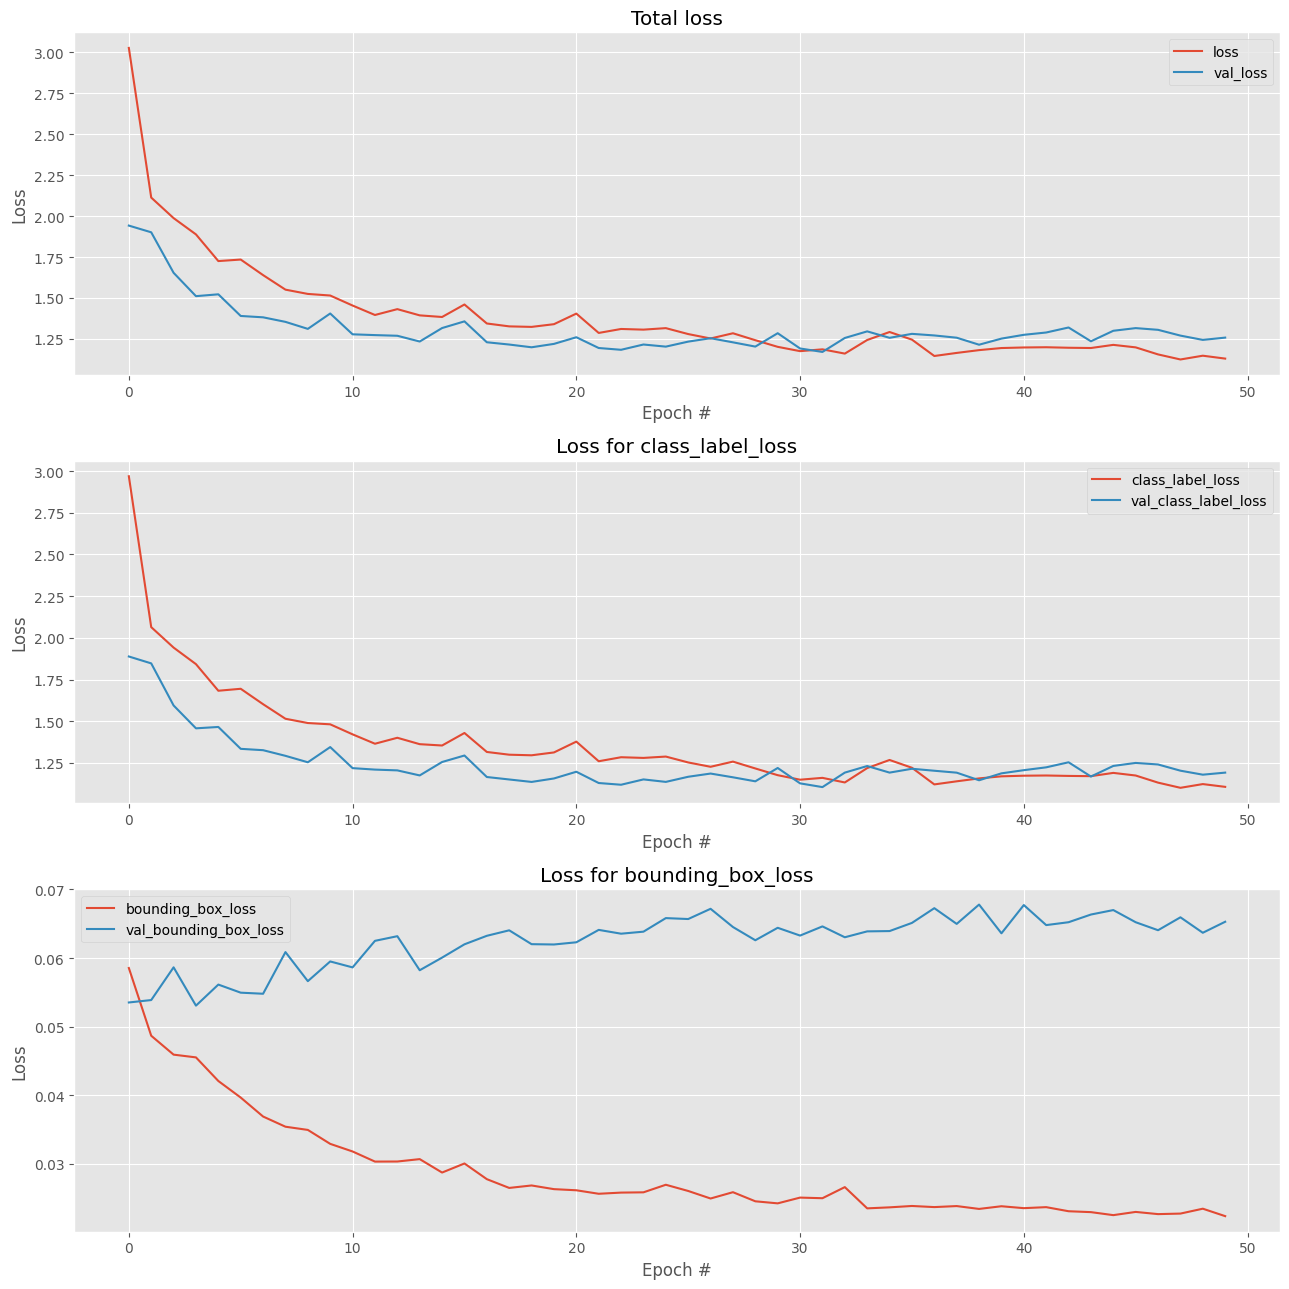

In [ ]:
# plot the total loss, label loss, and bounding box loss
epochs=50
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

#### **Visualizes two accuracy components: bounding box loss, class label loss**

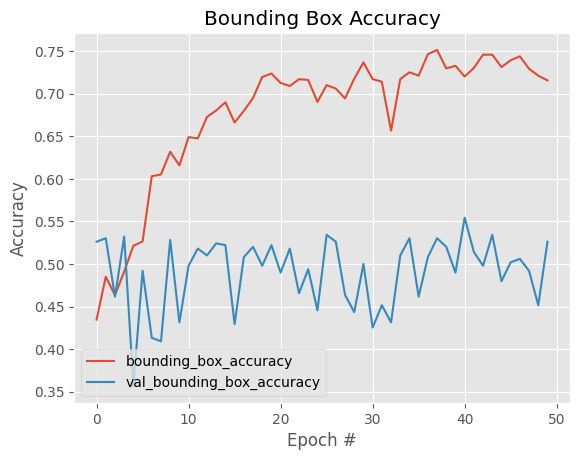

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


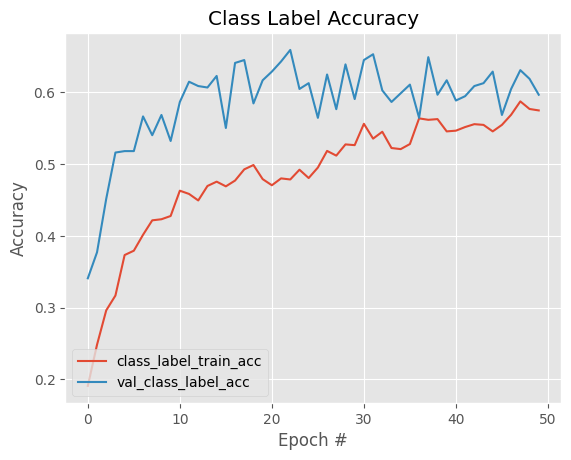

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


#### Predict multi-class objects

In [ ]:
img = '/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'
#img = '/content/crop-disease-ghana/input/Tomato/Tomato__Septoria/images/2N8A0600.JPG'

In [ ]:
# loop over the images that we'll be testing using our bounding box
# regression model
#for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]

image = load_img(img, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = modell.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
# determine the class label with the largest predicted
# probability
i = np.argmax(labelPreds, axis=1)
label = label_binarizer.classes_[i][0]

1/1 [==============================] - 0s 487ms/step


In [ ]:
print(startX, startY, endX, endY)

0.54288334 0.51715934 0.6258746 0.61109596


In [ ]:
print(label)

Corn Common Rust


217 310 250 366


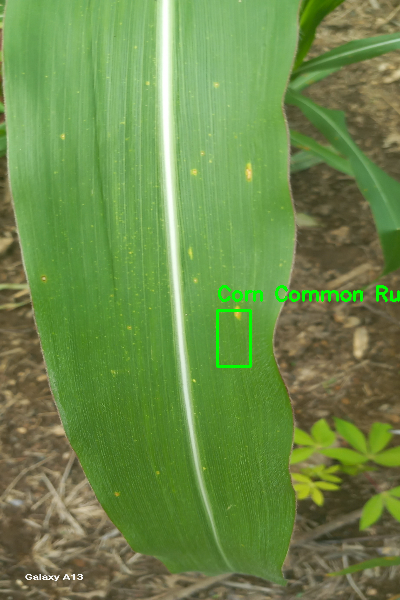

-1

In [ ]:
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
from imutils import paths

image = cv2.imread(img)
image = image.copy()
image = cv2.resize(image, (400, 600))
#image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX, startY, endX, endY)
# draw the predicted bounding box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

### **Model Prediction and Matrix**

In [ ]:
scores = modell.evaluate(testImages, testTargets)
print(f"Test Bounding Box Accuracy: {scores[3]*100}")
print(f"Test Class Label Accuracy: {scores[4]*100}")

16/16 [==============================] - 1s 48ms/step - loss: 1.2575 - bounding_box_loss: 0.0653 - class_label_loss: 1.1922 - bounding_box_accuracy: 0.5262 - class_label_accuracy: 0.5968
Test Bounding Box Accuracy: 52.620965242385864
Test Class Label Accuracy: 59.67742204666138


In [ ]:
pred_test=modell.predict(testImages)

16/16 [==============================] - 1s 42ms/step


In [ ]:

# Reshape to remove the redundant dimension
converted_coordinates = testBBoxes.reshape((testBBoxes.shape[0], testBBoxes.shape[1]))

print(converted_coordinates)

[[0.45542297 0.66766346 0.5261052  0.70759094]
 [0.4472397  0.45805028 0.5366876  0.5310316 ]
 [0.5735199  0.22531866 0.67679214 0.2906433 ]
 ...
 [0.441478   0.43594    0.4965056  0.5346279 ]
 [0.6053255  0.32573956 0.64561933 0.36646754]
 [0.30718216 0.3675907  0.39954984 0.44447142]]


In [ ]:
from sklearn.metrics import mean_squared_error

mse_bbox = mean_squared_error(converted_coordinates, pred_test[0])

#### MSE of bounding box predictions

In [ ]:
print(f"Test Bounding Box Mean Square Error: {mse_bbox*100}")

Test Bounding Box Mean Square Error: 6.52831494808197


In [ ]:
binary_predictions = np.argmax(pred_test[1] , axis=1).astype(int)

In [ ]:
# threshold = 0.5
# binary_predictions = (pred_test[1] > threshold).astype(int)

In [ ]:
testLabelsNonBinary=testLabels.argmax(axis=1)

#### F1 Score, Accuracy, Precision and Recall of class label prediction

In [ ]:
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

f1_test = f1_score(testLabelsNonBinary, binary_predictions, average='weighted')
print(f"Test Classifications F1 score: {f1_test*100}")
accuracy = accuracy_score(testLabelsNonBinary, binary_predictions)
print(f"Test Classifications accracy: {accuracy*100}")
# precision tp / (tp + fp)
precision = precision_score(testLabelsNonBinary, binary_predictions, average='weighted')
print(f"Test Classifications precision: {precision*100}")
# recall: tp / (tp + fn)
recall = recall_score(testLabelsNonBinary, binary_predictions, average='weighted')
print(f"Test Classifications recall: {recall*100}")

Test Classifications F1 score: 59.705838466327286
Test Classifications accracy: 59.67741935483871
Test Classifications precision: 63.84565384949366
Test Classifications recall: 59.67741935483871


In [ ]:
def evaluating_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.figure(figsize=(7, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Reds');
    plt.title('Confusion Matrix');
    plt.xlabel('Predicted Labels');
    plt.ylabel('Actual Labels');
    plt.tight_layout();

    print(classification_report(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.64      0.68      0.66        34
           1       0.70      0.74      0.72        38
           2       0.93      0.84      0.88        50
           3       0.58      0.67      0.62        45
           4       0.69      0.53      0.60        34
           5       0.36      0.36      0.36        45
           6       0.00      0.00      0.00        46
           7       0.23      0.63      0.34        35
           8       0.64      0.47      0.54        30
           9       0.77      0.59      0.67        51
          10       0.97      0.88      0.93        42
          11       0.74      0.80      0.77        35
          12       0.30      0.55      0.39        11

    accuracy                           0.59       496
   macro avg       0.58      0.59      0.57       496
weighted avg       0.60      0.59      0.58       496



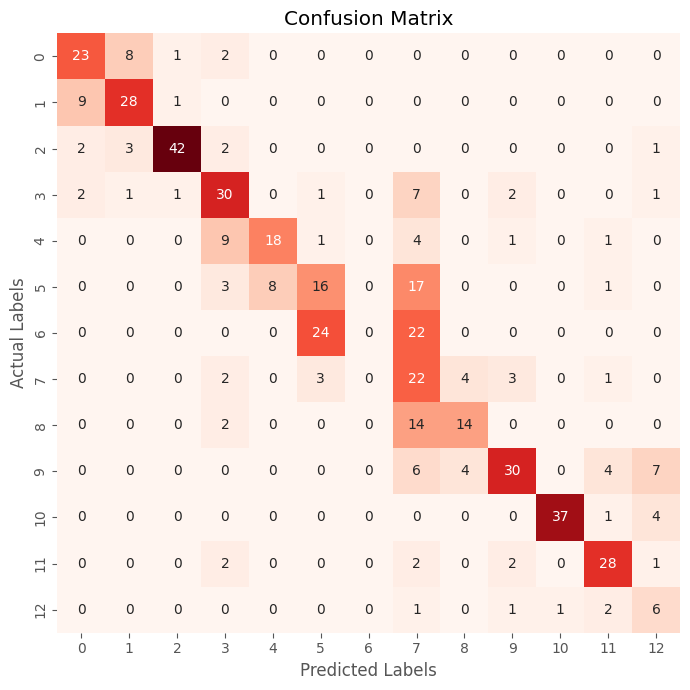

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
evaluating_model(testLabelsNonBinary, binary_predictions)